In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import numpy as np
import pandas as pd
from scipy.special import beta as beta_f
from scipy.stats import beta, gamma, binom, norm
from scipy.misc import factorial

import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 400
plt.rcParams['figure.figsize'] = 6, 4
plt.rcParams['text.usetex'] = True

# 1.

A survey was done of bicycle and other vehicular traffic in the neighborhood of the campus of the University of California, Berkeley, in the spring of 1993. Ten city blocks were selected at random; each block was observed for one hour, and the numbers of bicycles and other vehicles traveling along that block were recorded. The following table displays the number of bicycles and other vehicles recorded.

In [2]:
df = pd.read_csv('data/traffic_counts.csv')
df.T

,0,1,2,3,4,5,6,7,8,9
bicycles,16,9,10,13,19,20,18,17,35,55
others,58,90,48,57,103,57,86,112,273,64


Set up a model for these data so that, for $j = 1,...,J = 10$, the observed number of bicycles at location $j$ is binomial with unknown probability $\theta_j$, and sample size equal to the total number of vehicles (bicycles included) in that block, that is,

<center>$y_i,...,y_j | \theta \sim indep\ Binomial(n_j, \theta_j)$</center>


The parameter $\theta_j$ can be interpreted as the underlying or ‘true’ proportion of traffic at location $j$ that is bicycles. Assign a beta population distribution for the parameters $\theta_j$, and a noninformative hyperprior distribuiton:

<center>$\theta_1,...,\theta_J \sim iid\ Beta(\alpha, \beta)$, where $p(\alpha, \beta) \propto (\alpha + \beta)^{-2}$</center>

<hr>

### (a) 

Write expressions for the joint, conditional, and marginal posterior distributions: $p(\theta, \alpha, \beta|y)$, $p(\theta|\alpha, \beta, y)$, and $p(\alpha, \beta|y)$.

<hr>

$p(y | \theta) \propto \prod \theta^{y_i}(1 - \theta)^{n - y_i}$

$p(\theta | \alpha, \beta) \propto \prod \frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha) \Gamma(\beta)} \theta^{y_i}(1 - \theta)^{n - y_i}$

$p(\alpha, \beta) = (\alpha + \beta)^{-2}$

$p(\theta, \alpha, \beta | y) \propto p(\alpha, \beta) p(\theta | \alpha, \beta) p(y | \theta)$
$\\$

$p(\theta | \alpha, \beta, y) \propto (\alpha + \beta)^{-2}  \frac{\Gamma(\alpha + \beta + n_j)}{\Gamma(\alpha + y_j) \Gamma(\beta + n_j - y_j)} \prod^J \theta^{\alpha + y_j - 1}(1 - \theta)^{\beta + n_j - y_j - 1}$

$p(\alpha, \beta | y) = \frac{p(\theta, \alpha, \beta | y)}{p(\theta | \alpha, \beta, y)} = (\alpha + \beta)^{-2} \prod^J\bigg[\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha) \Gamma(\beta)}  \frac{\Gamma(\alpha + \beta + n_j)}{\Gamma(\alpha + y_j) \Gamma(\beta + n_j - y_j)}\bigg]$

### (b)

Compute the posterior density of the logit prior mean and log prior ‘sample size’ $p(log(\alpha/\beta), log(\alpha + \beta)\ |\ y)$ on a grid of values, and plot the contours corresponding to .001, .01 and .05, .15,..., .95 times the maximum posterior density.

<hr>

In [3]:
y_vals = df.bicycles.values
n_vals = (df.bicycles + df.others).values

def inverse_logit(x):
    return 1. / (1 + np.exp(-x))

def logit(x):
    return np.log(x / (1. - x))

def compute_posterior(a, b, y, n, use_log=False):
    log_post = -2 * np.log(a + b)
    log_post -= len(y) * np.log(beta_f(a, b))
    for y_i, n_i in zip(y_vals, n_vals):
        log_post += np.log(beta_f(a + y_i, b + n_i - y_i))
    if use_log:
        return log_post
    return np.exp(log_post)

In [4]:
mu = np.mean(y_vals / n_vals)
psi = mu * (1 - mu) / np.var(y_vals / n_vals, ddof=1) - 1

print('logit(mu): {}\nlog(psi): {}'.format(logit(mu), np.log(psi)))

logit(mu): -1.4105885339941364
log(psi): 2.578555621465445


In [5]:
# define the domain
logit_mu = np.arange(-3, 0, .02)
log_psi = np.arange(0, 6, .02)

posterior_grid = np.empty((logit_mu.shape[0], log_psi.shape[0]))
for i, l_mu in enumerate(logit_mu):
    for j, l_psi in enumerate(log_psi):
        mu = inverse_logit(l_mu)
        psi = np.exp(l_psi)
        alpha = mu * psi
        beta = (1 - mu) * psi
        posterior_grid[i,j] = np.nan_to_num(np.log(alpha)) + np.nan_to_num(np.log(beta)) + \
                              compute_posterior(alpha, beta, y_vals, n_vals, True)

In [6]:
posterior_grid = posterior_grid - posterior_grid.max()
posterior_grid = np.exp(posterior_grid)
print(posterior_grid.shape)

(150, 300)


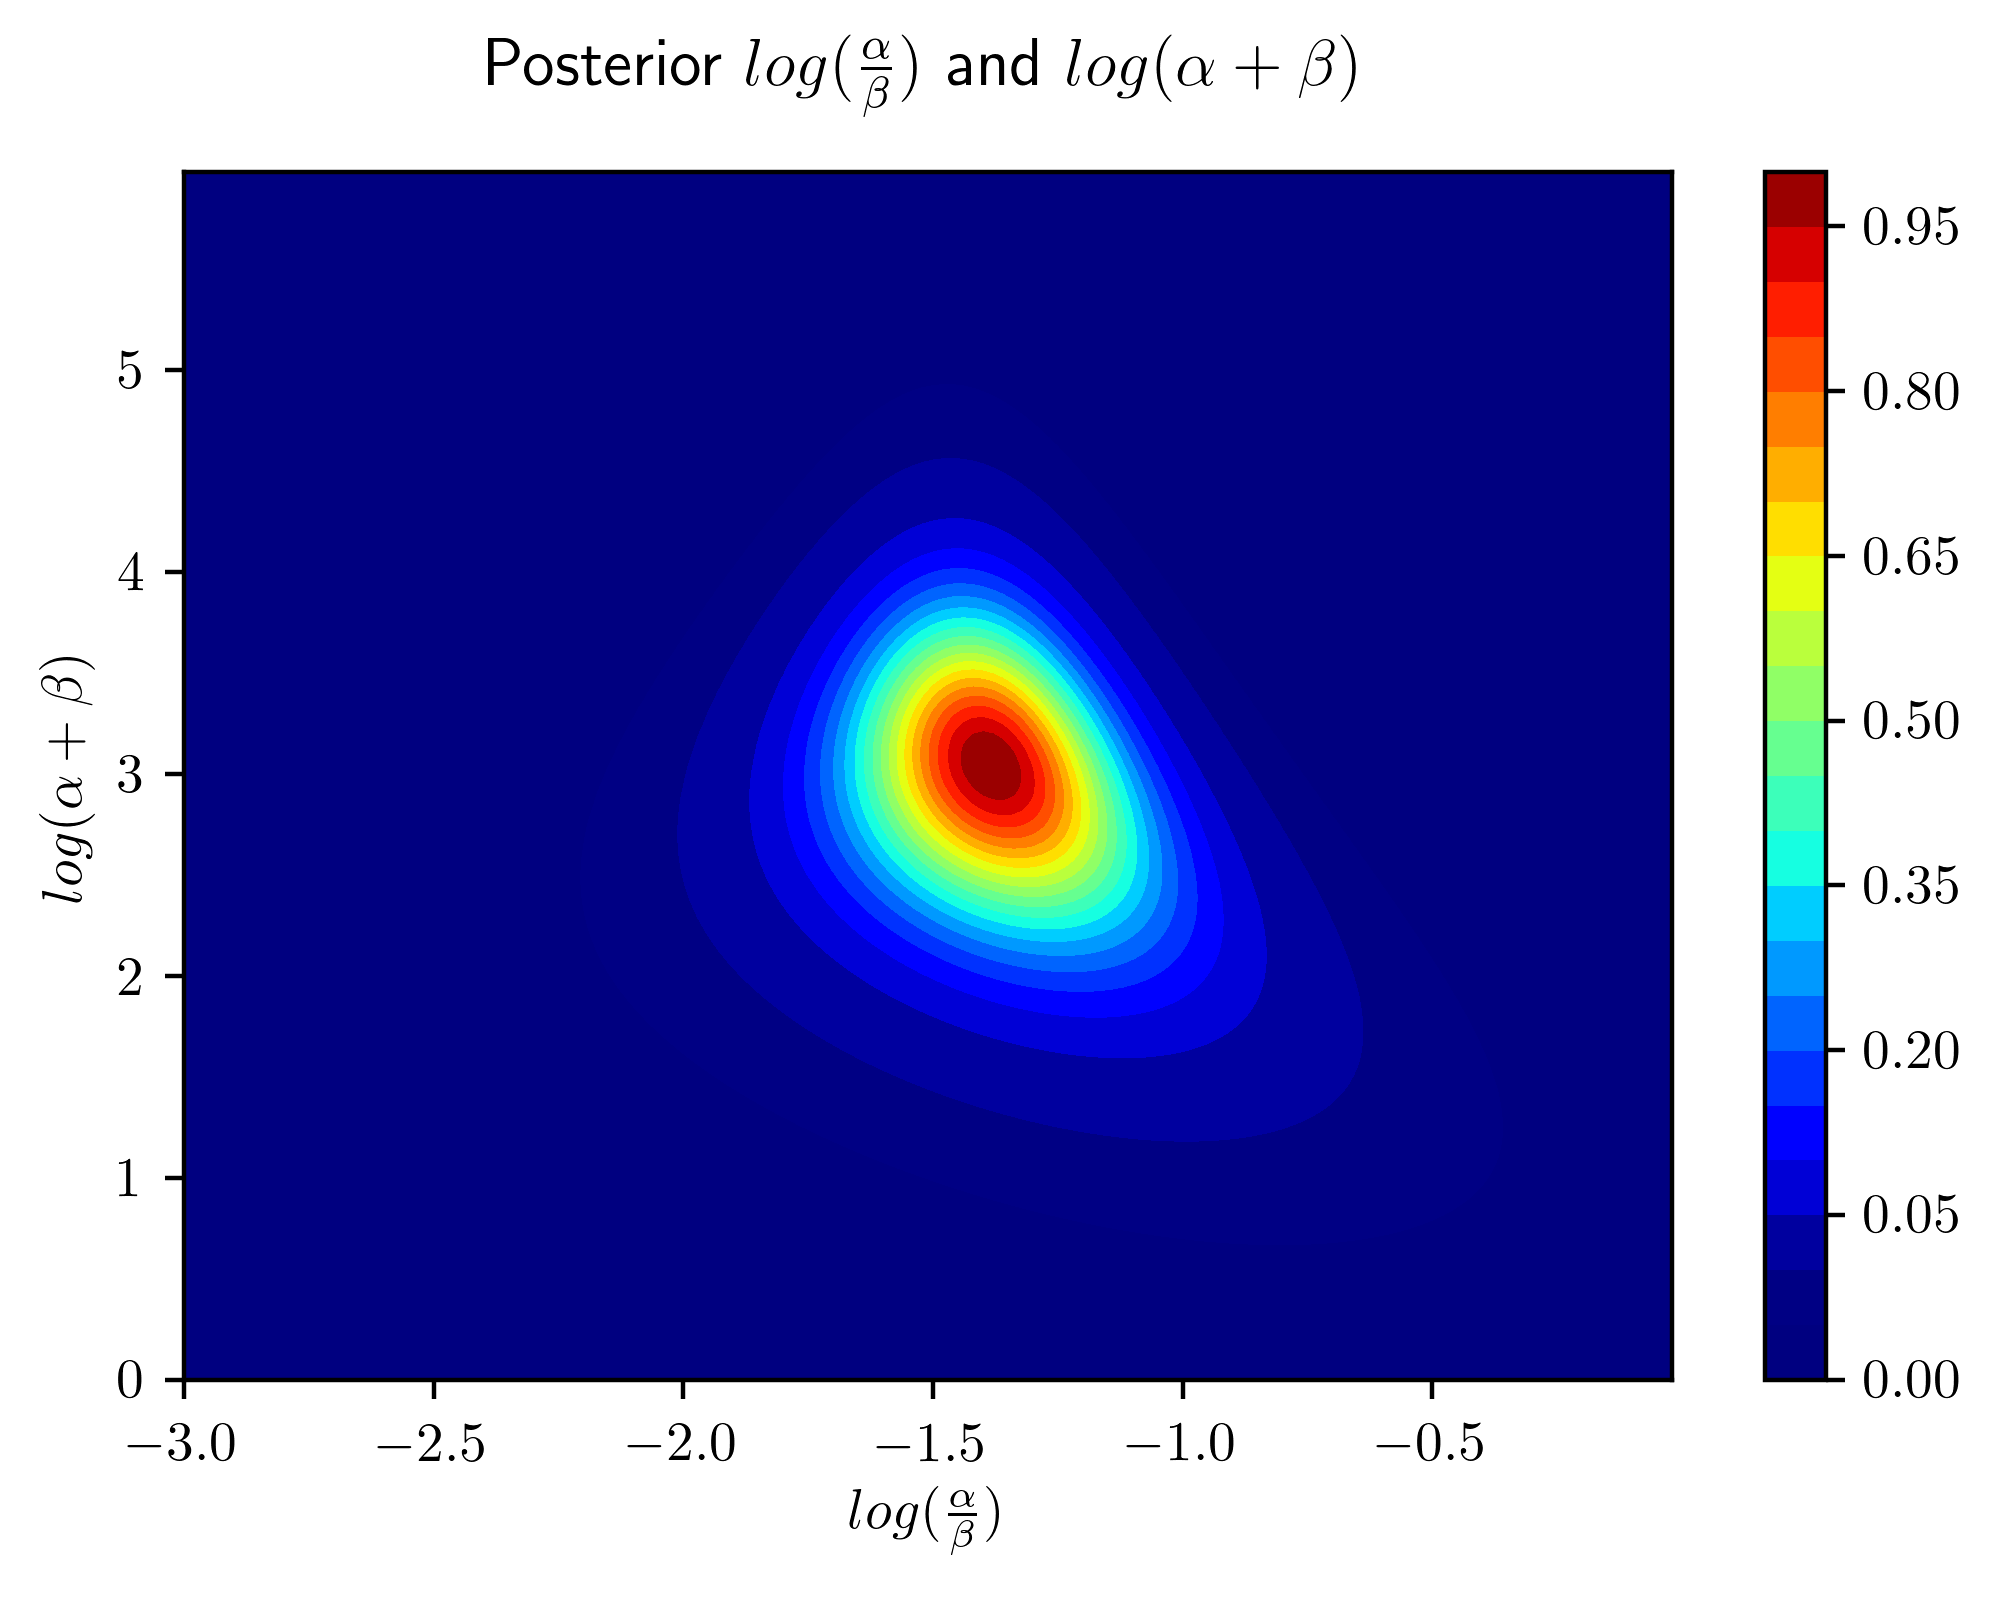

In [7]:
levels = [0, .001, .01] + [.05 * i for i in range(1, 21)]

# plot the posterior level curves
plt.contourf(logit_mu, log_psi, posterior_grid.T, levels=levels, cmap=plt.cm.jet)
plt.xlabel(r'$log(\frac{\alpha}{\beta})$')
plt.ylabel(r'$log(\alpha + \beta)$')
plt.title(r'Posterior $log(\frac{\alpha}{\beta})$ and $log(\alpha + \beta)$', y=1.025)
plt.colorbar()
plt.show()

### (c)

Draw 5000 simulations from the joint posterior distribution of the parameters and hyperparameters. Make a scatterplot of the simulations of $log(\frac{\alpha}{\beta})$ and $log(\alpha + \beta)$, on the same scale as your contour plot.

<hr>

In [8]:
def sample_posterior(n):
    prob_grid = posterior_grid / posterior_grid.sum()   # normalized
    mu_prob_marg = prob_grid.sum(axis=1)
    
    # we need the index to get the marginal for each beta
    mu_samples_ind = np.random.choice(list(range(logit_mu.shape[0])), n, replace=True, p=mu_prob_marg)
    mu_samples = logit_mu[mu_samples_ind]

    psi_samples = np.empty_like(mu_samples)
    
    for i, sample_ind in enumerate(mu_samples_ind):
        probs = posterior_grid[sample_ind] / posterior_grid[sample_ind].sum()
        psi_star = np.random.choice(log_psi, 1, replace=True, p=probs)
        psi_samples[i] = psi_star
        
    return np.c_[mu_samples, psi_samples]

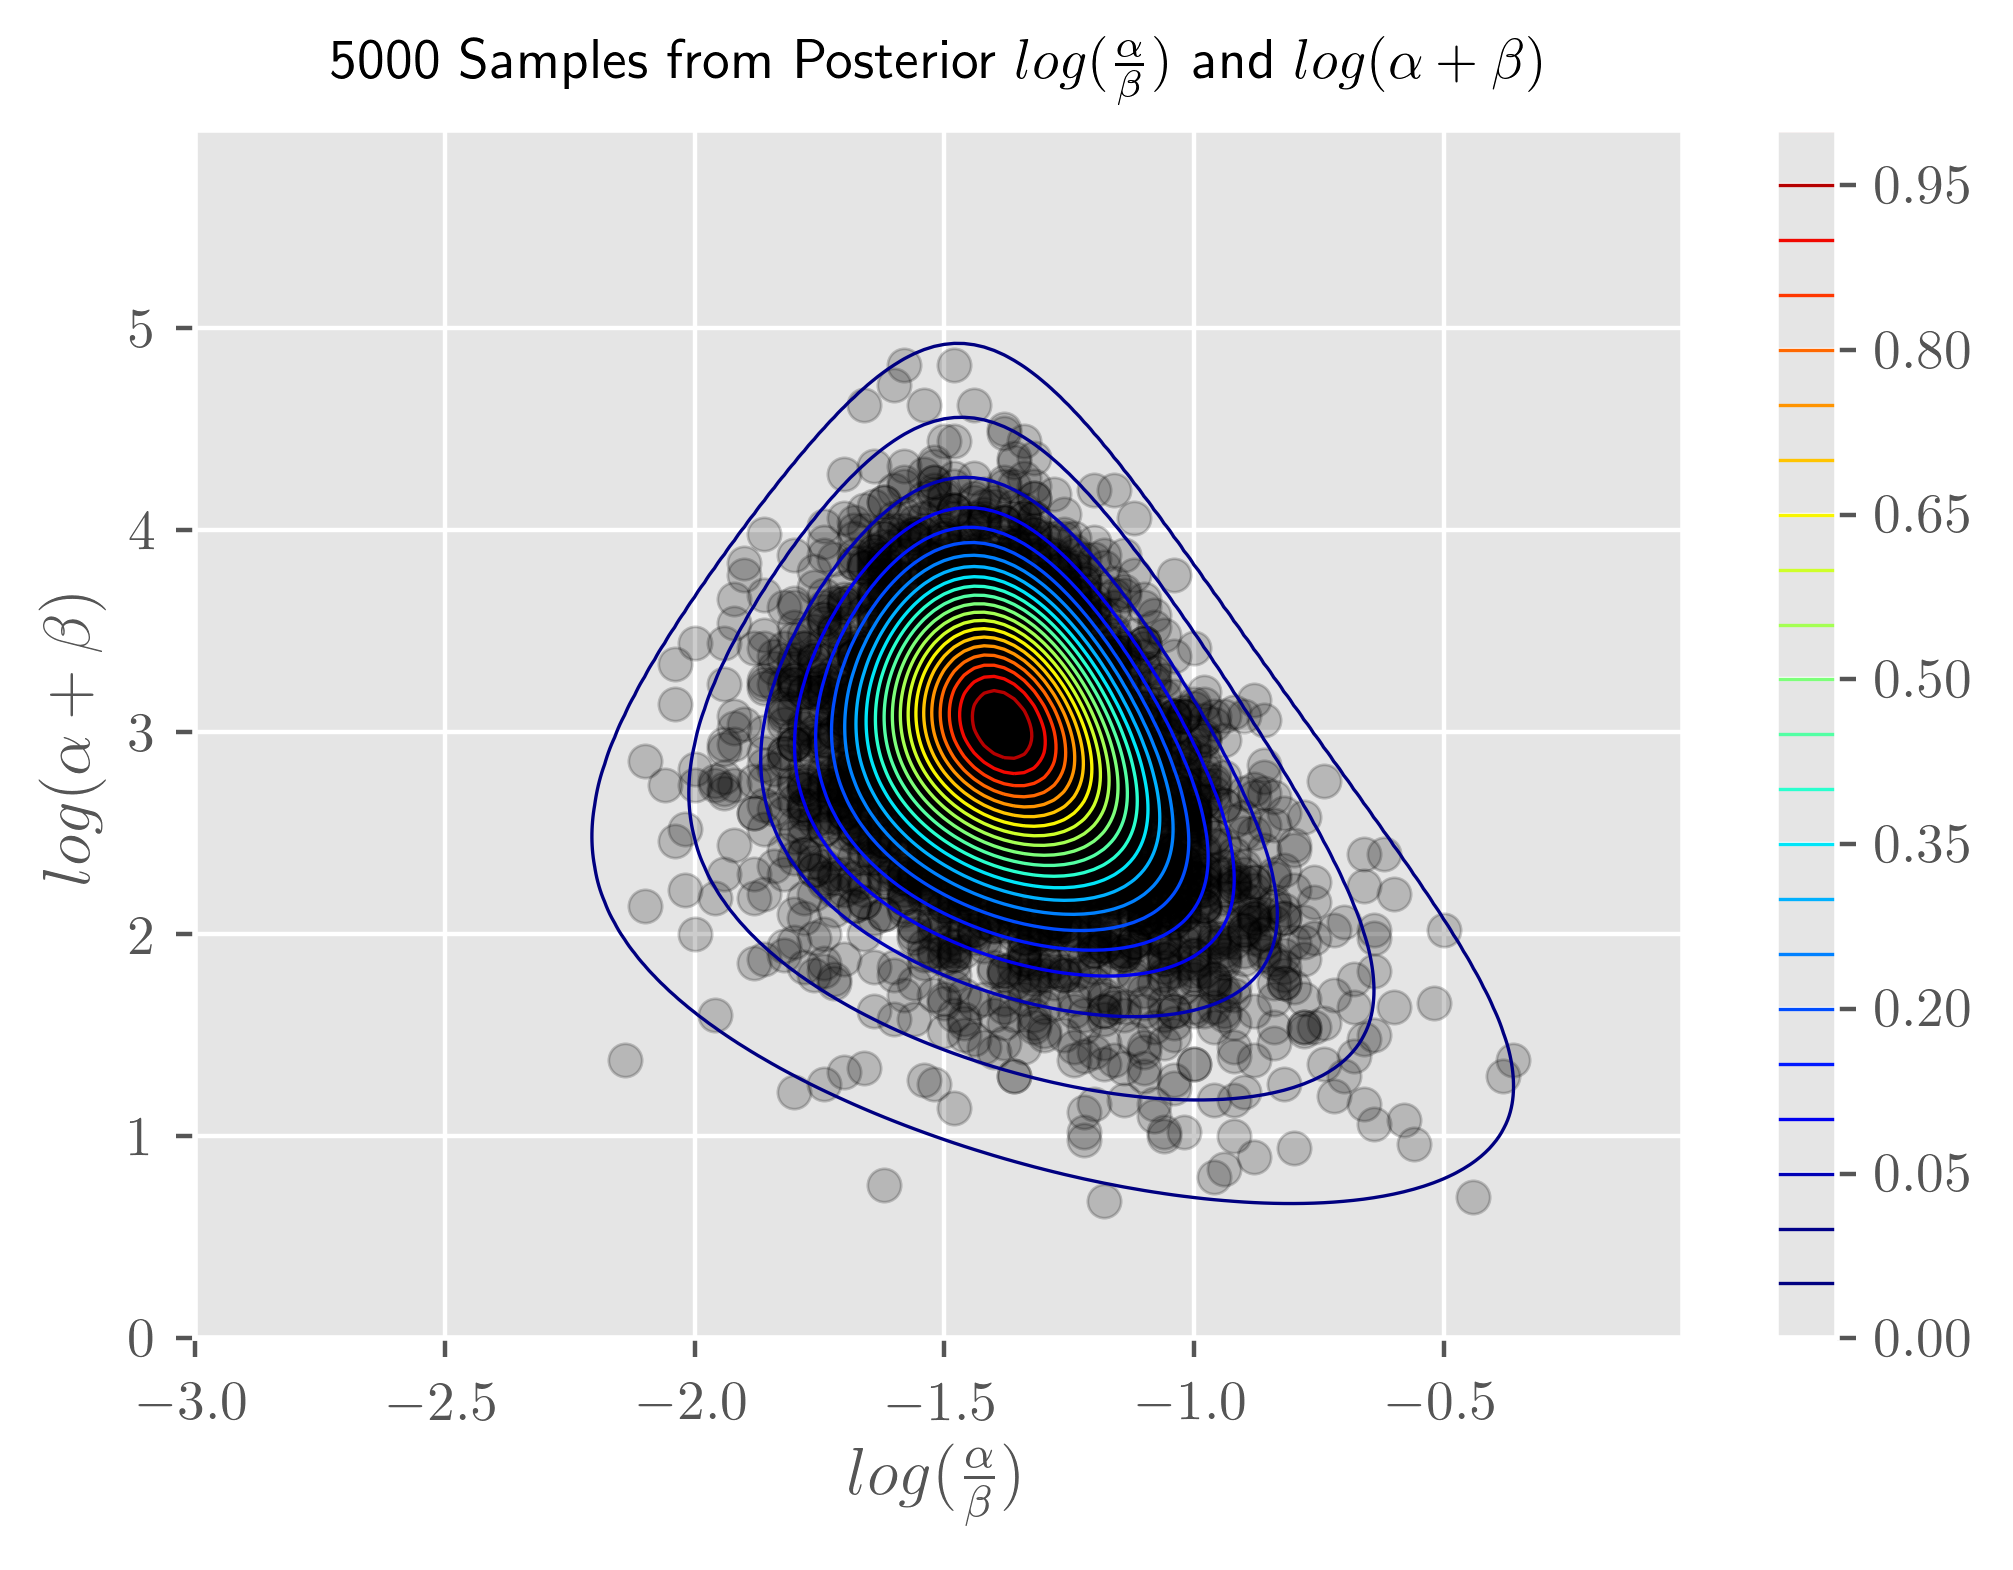

In [53]:
samples = sample_posterior(5000)

with plt.style.context('ggplot'):
    plt.scatter(samples[:,0], samples[:,1], color='black', alpha=.2)
    plt.contour(logit_mu, log_psi, posterior_grid.T, levels=levels, cmap=plt.cm.jet, linewidths=.6)
    plt.xlabel(r'$log(\frac{\alpha}{\beta})$')
    plt.ylabel(r'$log(\alpha + \beta)$')
    plt.colorbar()
    plt.title(r'5000 Samples from Posterior $log(\frac{\alpha}{\beta})$ and $log(\alpha + \beta)$',
              size=10)
    plt.show()

### (d)

Plot 95% posterior intervals for the parameters $\theta_j$ versus the raw proportions $\dfrac{y_j}{n_j}$ for $j = 1,...,J$.

<em>Sampling from the joint posterior distribution of parameters and hyperparameters.</em> We draw 1000 random samples from the joint posterior distribution of $(\alpha, \beta,\theta_1,...,\theta_j)$, as follows.

1. Simulate 1000 draws of $(log(\alpha),log(\alpha+\beta))$ from their posterior distribution displayed in Figure 5.3, using the same discrete-grid sampling procedure used to draw $(\alpha, \beta)$ for Figure 3.3b in the bioassay example of Section 3.8.

2. For $l = 1,...,100$:

   (a) Transform the lth draw of $(log(\alpha),log(\alpha+\beta))$ to the scale $(\alpha, \beta)$ to yield a draw of the hyperparameters from their marginal posterior distribution.
   
   (b) For each $j = 1,...,J$ sample $\theta_j$ from its conditional posterior distribution $\theta_j | \alpha, \beta, y \sim Beta(\alpha + y_j,\ \beta + n_j - y_j)$
   

<hr>

In [15]:
# transform the samples back
samples = sample_posterior(1000)
mu_sim = np.array([inverse_logit(x) for x in samples[:,0]])
psi_sim = np.exp(samples[:,1])
alpha_sim = mu_sim * psi_sim
beta_sim = (1 - mu_sim) * psi_sim

posterior_samples = np.zeros((y_vals.shape[0], alpha_sim.shape[0]))
for i, (y_i, n_i) in enumerate(zip(y_vals, n_vals)):
    for j, (a_sim, b_sim) in enumerate(zip(alpha_sim, beta_sim)):
        posterior_samples[i, j] = np.random.beta(a_sim + y_i, b_sim + n_i - y_i)

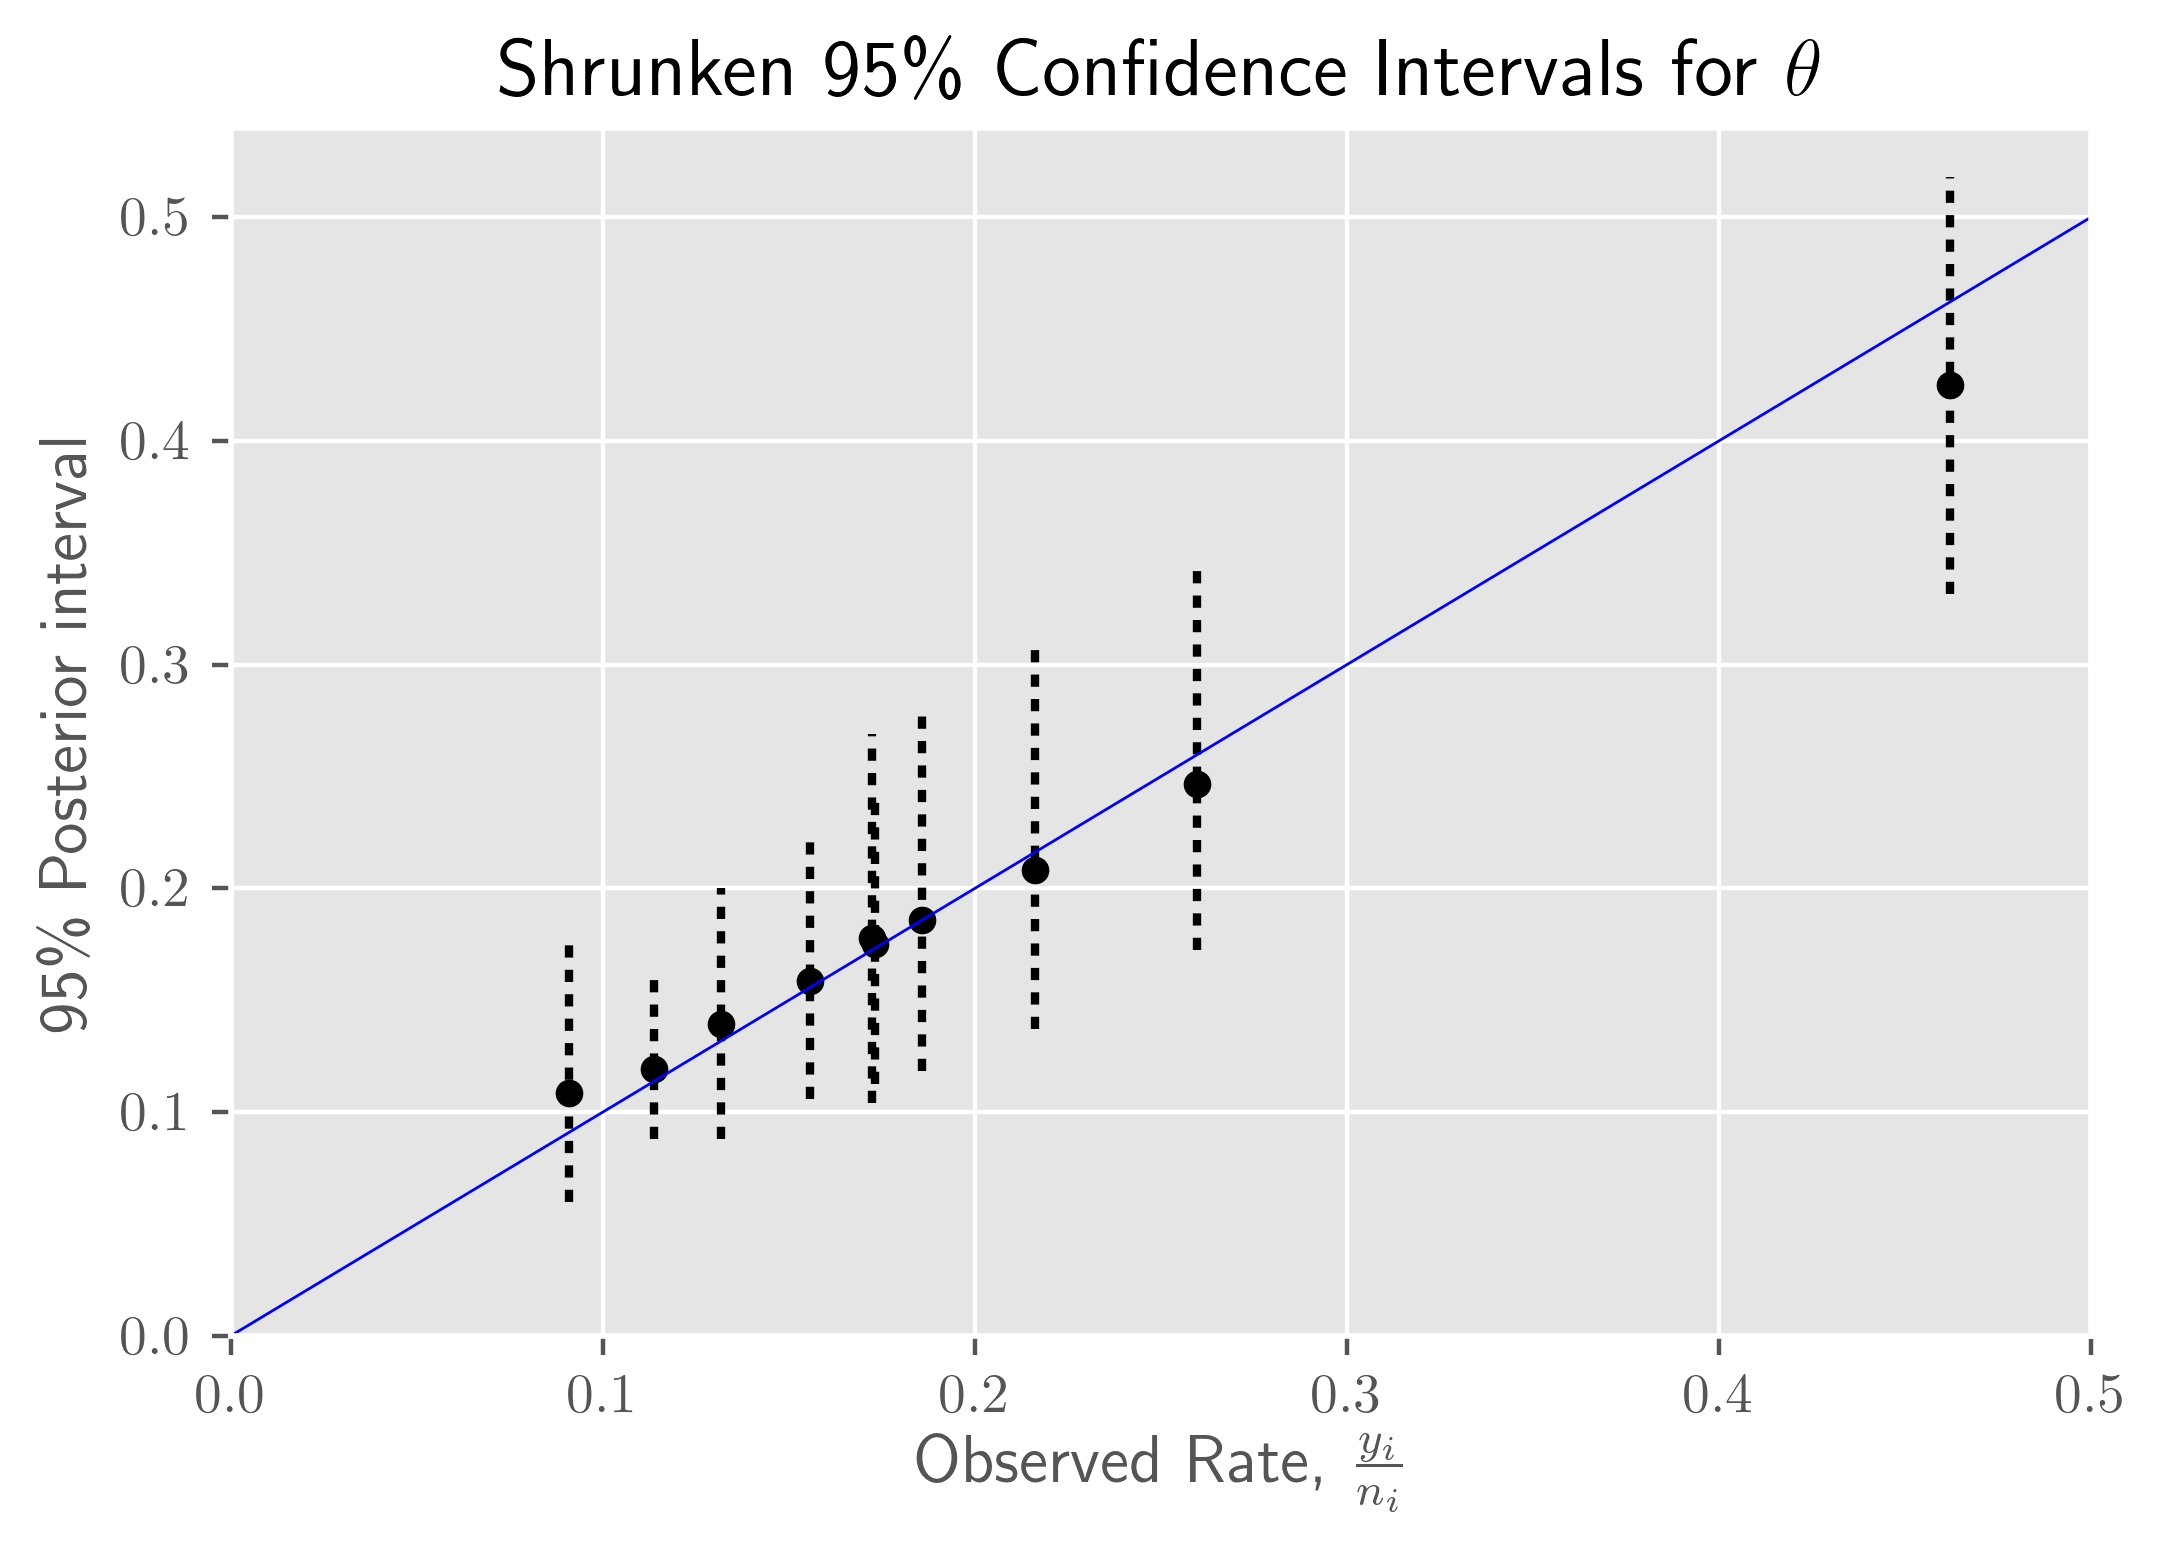

In [16]:
theta_obs = y_vals / n_vals
medians = np.median(posterior_samples, axis=1)
conf_intervals = np.percentile(posterior_samples, [2.5, 97.5], axis=1)
domain = np.linspace(0, .5, 100)
unpooled = domain

with plt.style.context('ggplot'):
    plt.scatter(theta_obs, medians, color='black', s=20)
    for theta_i, (lower, upper) in zip(theta_obs, conf_intervals.T):
        plt.vlines(x=theta_i, ymin=lower, ymax=upper, linestyle=':')
    plt.plot(domain, unpooled, linewidth=.5, color='blue')
    plt.xlim((.0, .5))
    plt.ylim((.0, .54))
    plt.xlabel(r'Observed Rate, $\frac{y_i}{n_i}$')
    plt.ylabel(r'95\% Posterior interval')
    plt.title(r'Shrunken 95\% Confidence Intervals for $\theta$')
    plt.show()

### (e)

Give a 95% posterior interval for $\mu = \frac{\alpha}{\alpha + \beta}$, the average underlying proportion of traffic that is bicycles.

<hr>

In [17]:
mu_sim = alpha_sim / (alpha_sim + beta_sim)
print('95% confidence interval: [{:.3f}, {:.3f}]'\
          .format(*np.percentile(mu_sim, [2.5, 97.5])))

95% confidence interval: [0.149, 0.285]


### (f)

A new city block is sampled at random and it is a residential street with a bike route. In an hour of observation, 100 vehicles of all kinds go by. Give a 95% posterior predictive interval for the number of those that are bicycles.

<hr>

In [19]:
theta_sim = np.random.beta(alpha_sim, beta_sim)
y_sim = theta_sim * 100
lower, upper = [int(x) for x in np.percentile(y_sim, [2.5, 97.5])]
print('95% confidence interval: [{}, {}]'.format(lower, upper))

95% confidence interval: [4, 48]


### (g)

A new city block is selected, but it is not "new" at all, it’s the first location in our sample, where we initially observed 16 bicycles and 58 other vehicles. This location is observed for an additional hour, in which 100 vehicles of all kinds go by. Give a 95% posterior predictive interval for the number of those that are bicycles.

<hr>

In [20]:
theta_sim = np.random.beta(alpha_sim + 16, beta_sim + 58)
y_sim = theta_sim * 100
lower, upper = [int(x) for x in np.percentile(y_sim, [2.5, 97.5])]
print('95% confidence interval: [{}, {}]'.format(lower, upper))

95% confidence interval: [13, 30]


# 2.

The data in the file ` meta.txt` summarize mortality after myocardial infarction in 22 clinical trials, each consisting of two groups of heart attack patients randomly allocated to receive or not receive beta-blockers. If clinical trial $j$ involves the use of $n_{0j}$ subjects in the control group and $n_{1j}$ in the treatment group, giving rise to $y_{0j}$ and $y_{1j}$ deaths in control and treatment groups, respectively, then the usual sampling model involves two independent binomial distributions with probabilities of death $p_{0j}$ and $p_{1j}$, respectively. An estimand of interest is the odds ratio, $\rho_j = \frac{p_{1j}}{1 - p_{1j}} \big{/} \frac{p_{0j}}{1 - p_{0j}}$.

For each study $j$, one can estimate the log odds ratio $\theta_j = log(\rho_j)$ by

$y_j = log\big{(}\frac{y_{1j}}{n_{1j} - y_{1j}}\big{)} - log\big{(}\frac{y_{0j}}{n_{0j} - y_{0j}}\big{)}$

with approximate sampling variance

$\sigma^2_j = \frac{1}{y_{1j}} + \frac{1}{n_{1j} - y_{1j}} + \frac{1}{y_{0j}} + \frac{1}{n_{0j} - y_{0j}}$

We use a hierarchical Bayesian analysis to combine information from the 22 studies and gain improved estimates of each $\theta_j$ , along with estimates of the mean and variance of the effects over all studies.

The first stage of the hierarchical model assumes that

$y_1,...,y_j | \theta \sim\ indep \ Normal(\theta_j, \sigma^2_j)$

where the $\sigma^2_j$ are assumed known. At the second stage of the hierarchy, we assume that

$\theta_1,...,\theta_j |\ \mu, \tau \sim\ indep \ Normal(\mu, \tau^2)$

Model specification is completed by the noninformative hyperprior

$p(\mu,\tau) = p(\mu|\tau)p(\tau) \propto p(\tau) \propto 1$

In [21]:
df = pd.read_csv('data/meta.csv')
y_1 = df['treated_deaths'].values
n_1 = df['treated_total'].values
y_0 = df['control_deaths'].values
n_0 = df['control_total'].values

df

,control_deaths,control_total,treated_deaths,treated_total
0,3,39,3,38
1,14,116,7,114
2,11,93,5,69
3,127,1520,102,1533
4,27,365,28,355
5,6,52,4,59
6,152,939,98,945
7,48,471,60,632
8,37,282,25,278
9,188,1921,138,1916


### (a) 
Plot the posterior density of $\tau$ over an appropriate range that includes essentially all of the posterior probability.

<hr>

In [22]:
def odds_ratio(y_1, n_1, y_0, n_0):
    return np.log(y_1 / (n_1 - y_1)) - np.log(y_0 / (n_0 - y_0))

def sample_variance(y_1, n_1, y_0, n_0):
    return (1. / y_1) + (1. / (n_1 - y_1)) + \
           (1. / y_0) + (1. / (n_0 - y_0))

def compute_log_posterior(tau, y, sigma_2):
    V = 1. / np.sum(1. / (sigma_2 + tau**2))
    mu_hat =  V * np.sum(y / (sigma_2 + tau**2))    
    log_post = (np.log(V) - np.sum(np.log(sigma_2 + tau**2))) / 2.
    log_post -= 0.5 * np.sum((y - mu_hat)**2 / (sigma_2 + tau**2))
        
    return log_post

In [46]:
sigma_2 = sample_variance(y_1, n_1, y_0, n_0)
y = odds_ratio(y_1, n_1, y_0, n_0)

tau_range = np.linspace(0, .6, 100)
tau_posterior = np.empty_like(tau_range)

for i, tau_star in enumerate(tau_range):
    tau_posterior[i] = compute_log_posterior(tau_star, y, sigma_2)

# scale to max value
tau_posterior -= tau_posterior.max()
tau_posterior = np.exp(tau_posterior)
tau_posterior = tau_posterior / tau_posterior.sum()

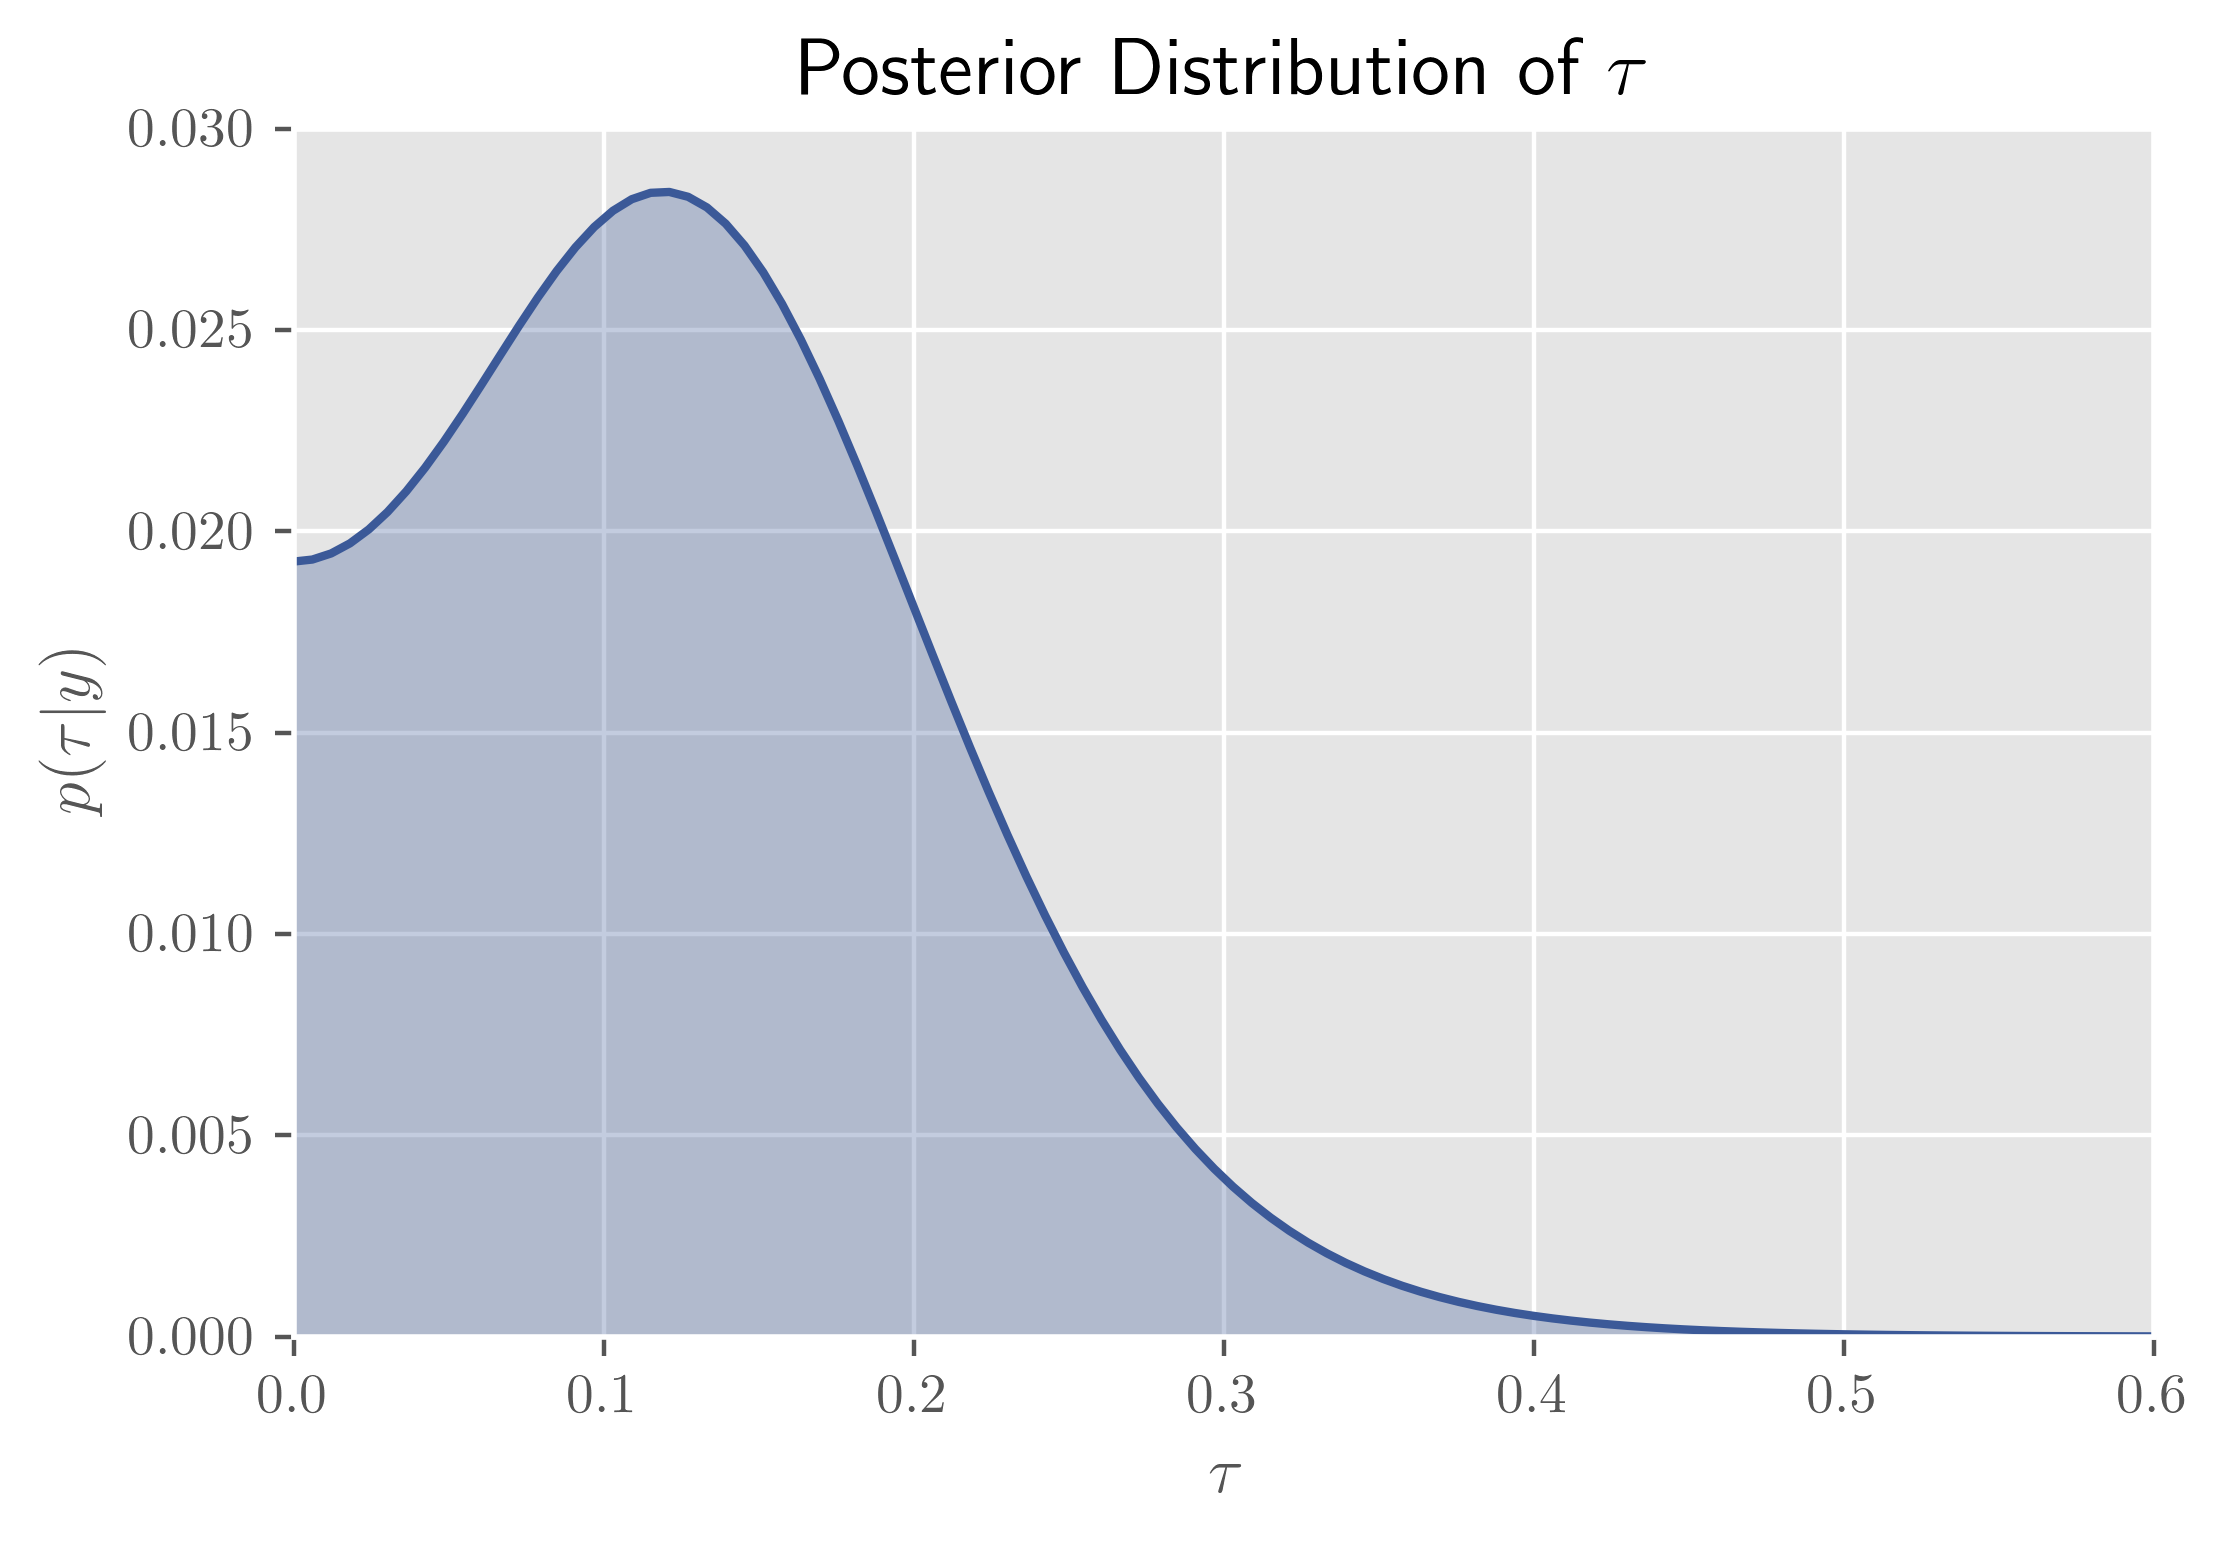

In [51]:
with plt.style.context('ggplot'):
    plt.plot(tau_range, tau_posterior, color='#3b5998')
    plt.fill_between(tau_range, 0, tau_posterior, color='#3b5998', alpha=.3)
    plt.xlabel(r'$\tau$')
    plt.ylabel(r'$p(\tau | y)$')
    plt.xlim(0, .6)
    plt.ylim(0, .03)
    plt.title(r'Posterior Distribution of $\tau$')
    plt.show()

### (b)

Plot the posterior mean treatment effects, $E(\theta_j|\tau,y)$, as functions of the between study standard deviation $\tau$, over a range that includes essentially all the posterior probability of $\tau$. Identify the study for which this quantity is maximized. Is it also the study with the maximum $y_j$? Explain.

<hr>

In [27]:
t_domain = np.linspace(.001, 1, 100)
ete = np.zeros((t_domain.shape[0], y.shape[0]))
for i, tau in enumerate(t_domain):
    V_inv = np.sum(1 / (sigma_2 + tau**2))
    mu_hat = np.sum(y / (sigma_2 + tau**2)) / V_inv
    ete[i] = ((y/sigma_2) + (mu_hat/tau**2)) / ((1./sigma_2) + (1./tau**2))

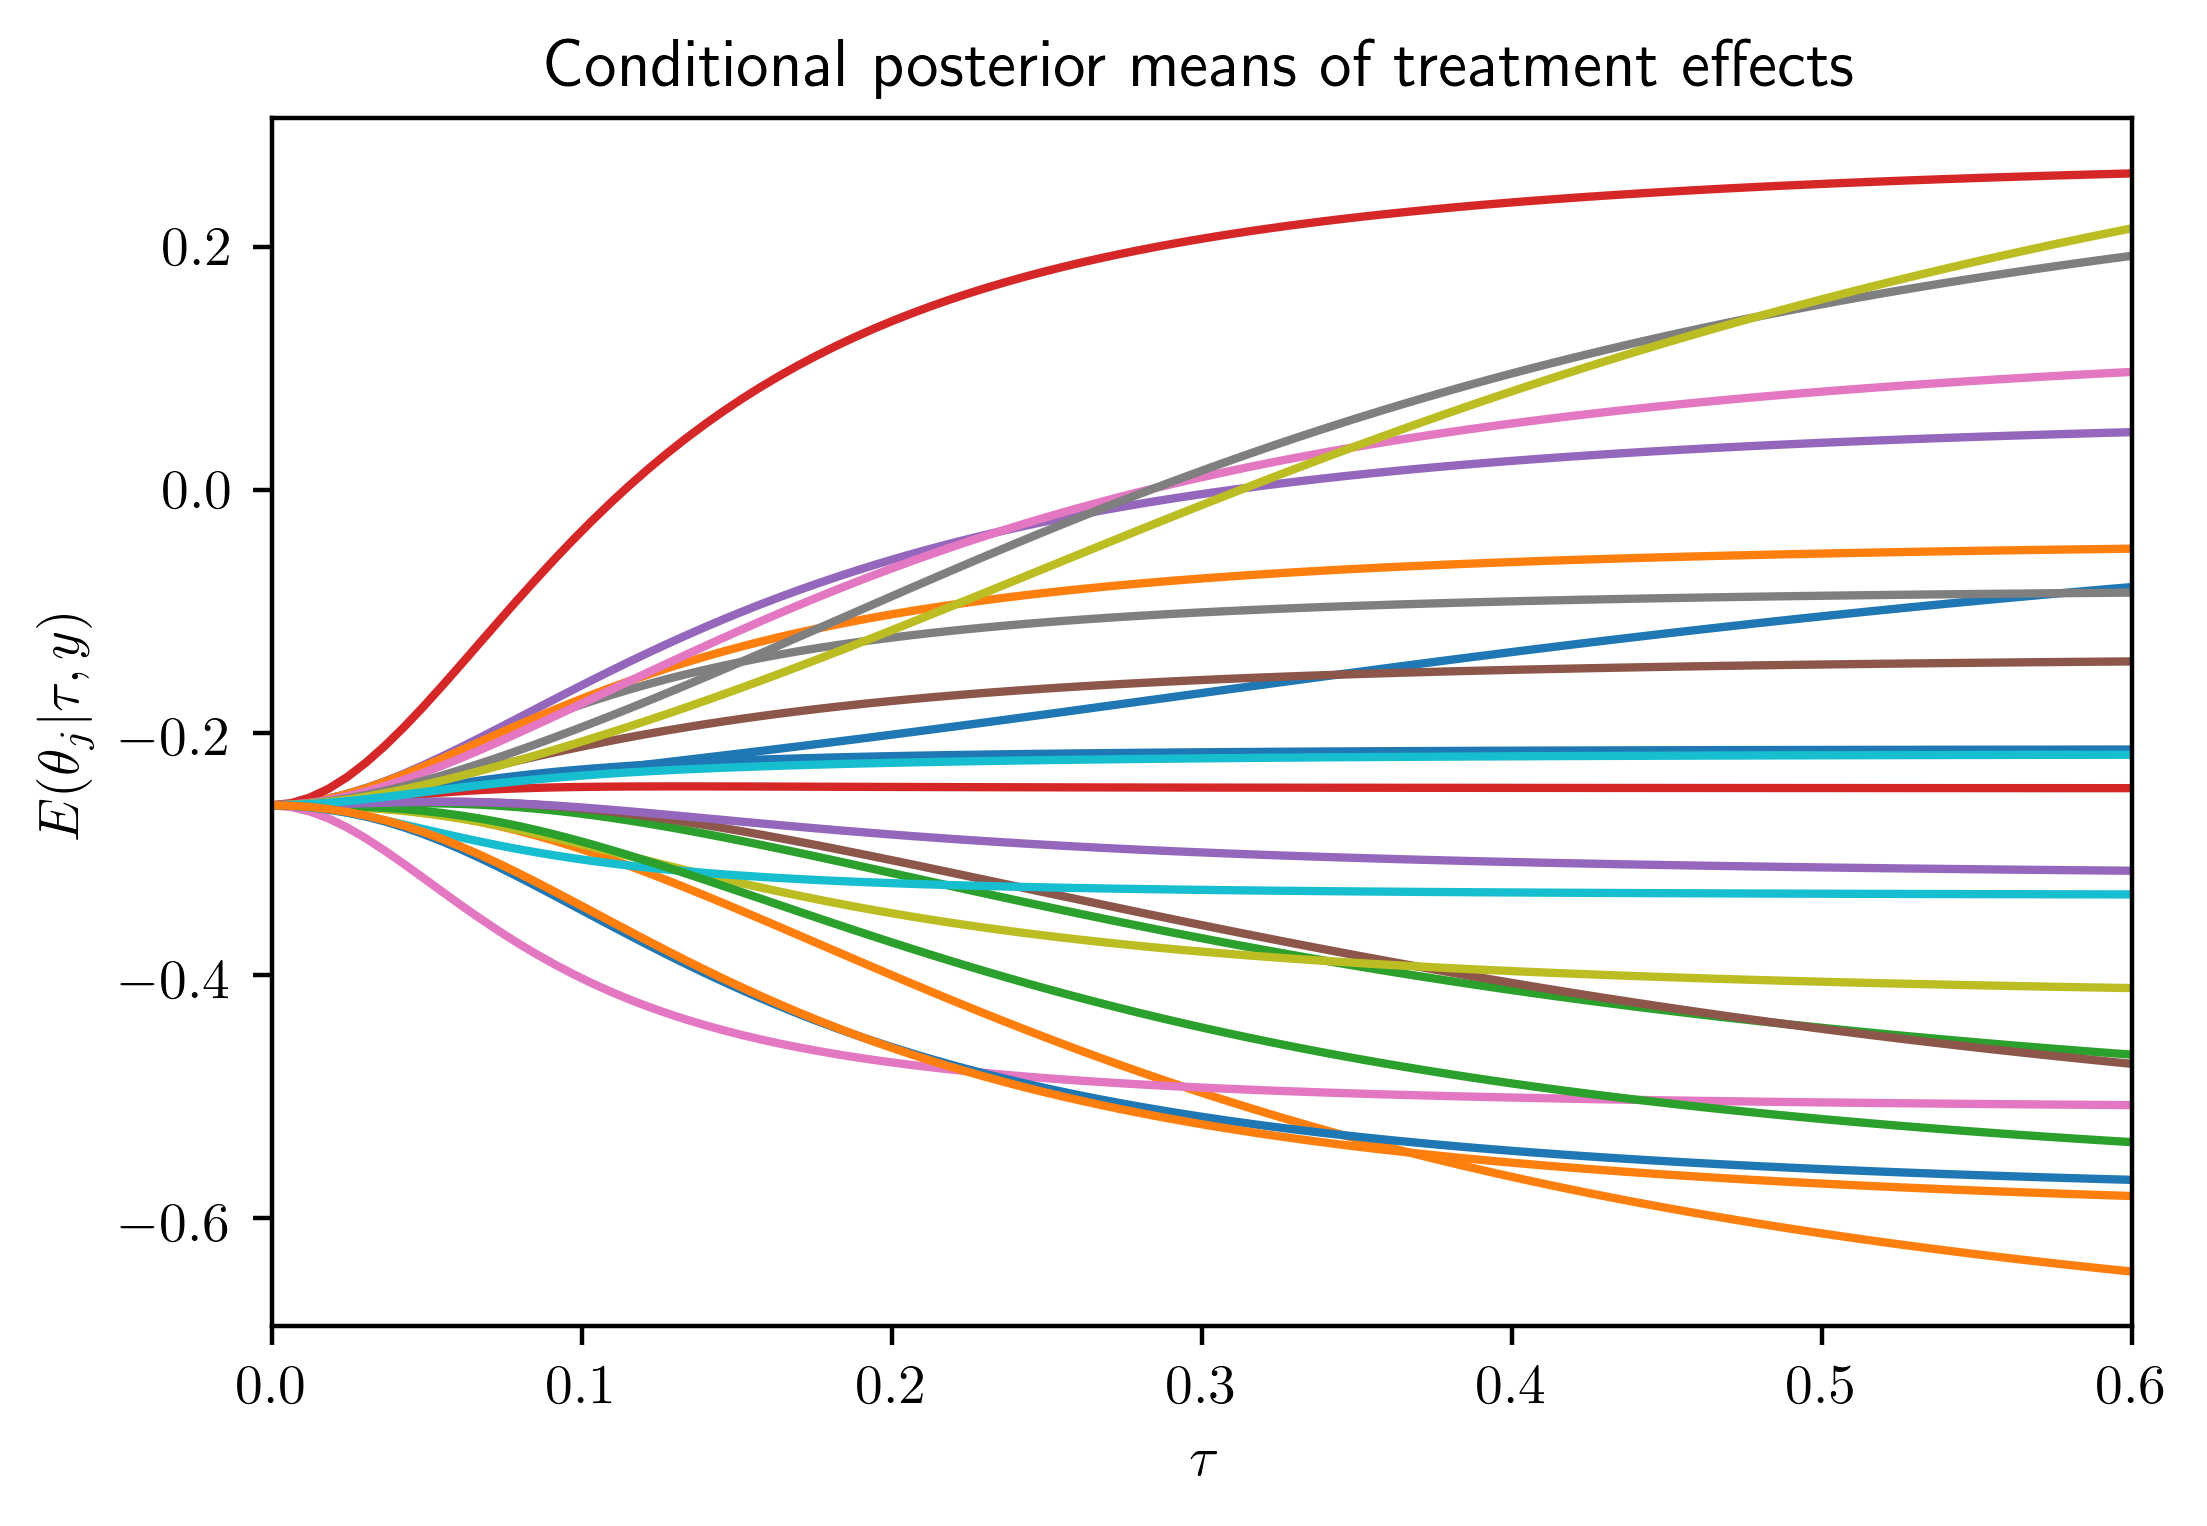

In [29]:
for theta_tau in ete.T:
    plt.plot(tau_range, theta_tau)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$E(\theta_j | \tau, y)$')
plt.xlim(0, 0.6)
plt.title(r'Conditional posterior means of treatment effects')
plt.show()

### (c) 

Plot the posterior standard deviations of treatment effects, $sd(\theta_j |\tau, y)$, as functions of the between-study standard devotion $\tau$, over a range that includes essentially all the posterior probability of $\tau$. Identify the study for which this quantity is maximized, and that for which it is minimized. What about these two studies causes them to stand apart from the other 20 in this plot?

<hr>

In [30]:
t_domain = np.linspace(0, 5, 100) + .00001
vte = np.zeros((t_domain.shape[0], y.shape[0]))
for i, tau in enumerate(t_domain):
    V = 1. / ((1./sigma_2) + (1./tau**2))
    V_mu = 1. / np.sum((1 / (sigma_2 + tau**2)))
    vte[i] = V + V**2 * V_mu / tau**4

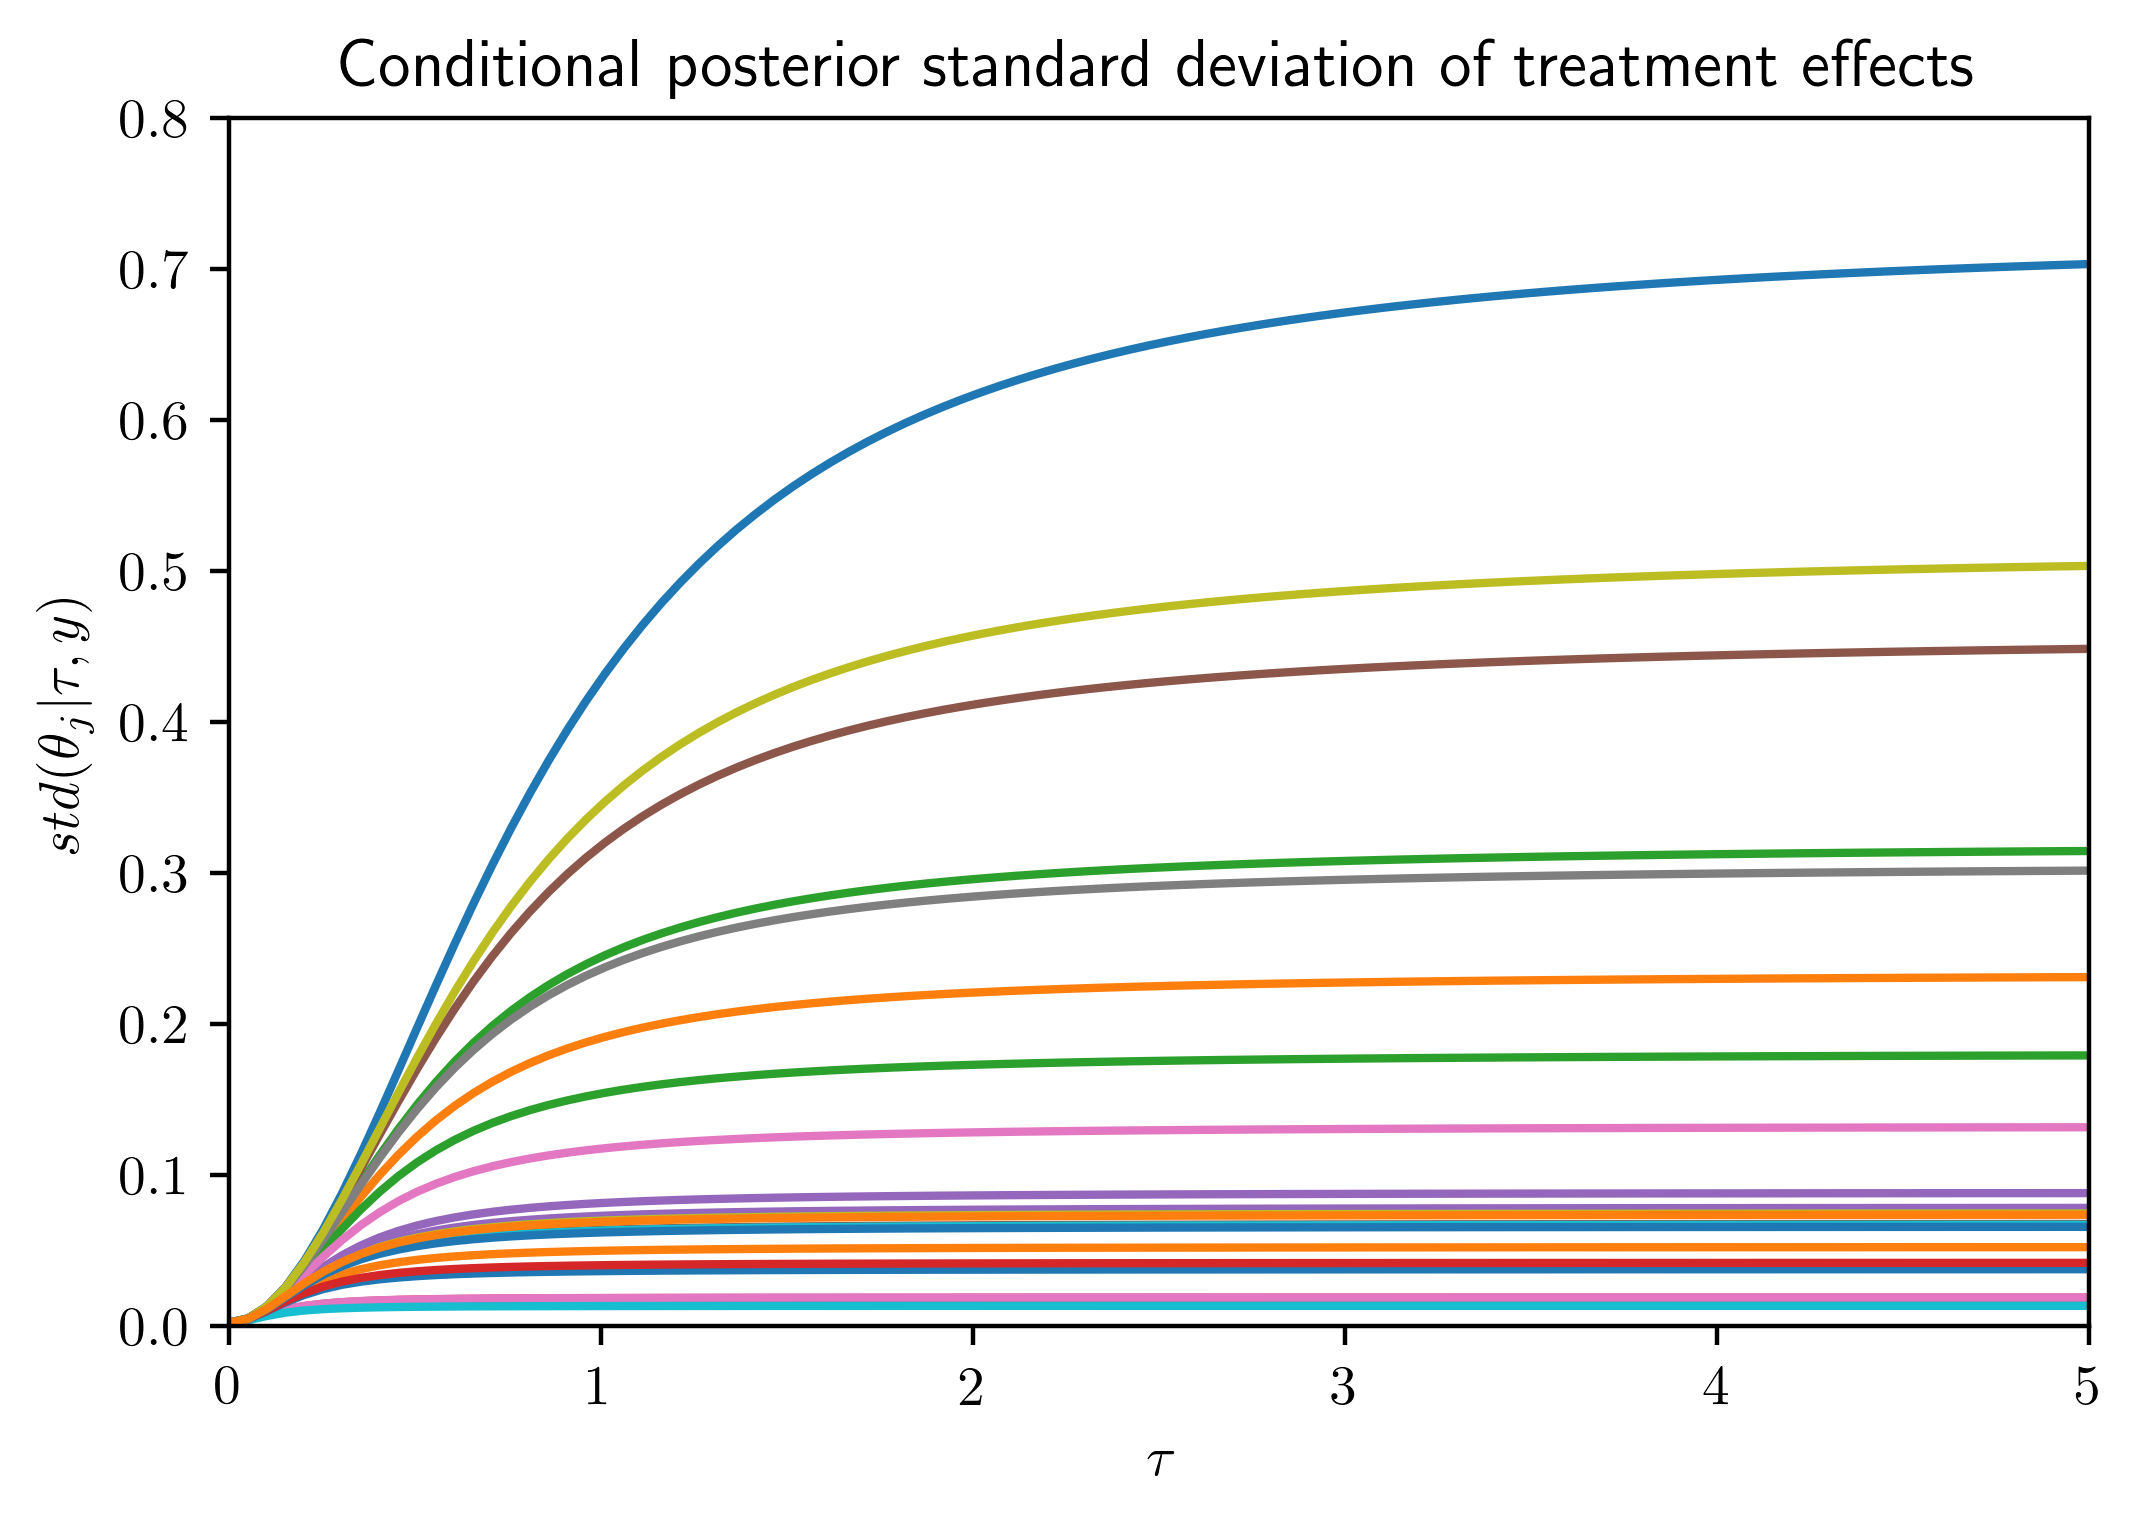

In [31]:
for theta_tau in vte.T:
    plt.plot(t_domain, theta_tau)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$std(\theta_j | \tau, y)$')
plt.xlim(0, 5)
plt.ylim(0, .8)
plt.title(r'Conditional posterior standard deviation of treatment effects')
plt.show()

In [32]:
# we can use the argmin+1 and argmax+1 as the studies that maximize 
# and minimize the function

print('study {} maximizes the function'.format(np.argmax(sigma_2) + 1))
print('study {} minimizes the function'.format(np.argmin(sigma_2) + 1))

study 1 maximizes the function
study 10 minimizes the function


This study is maximized for study number 1. This is because the study has very few participants and the observation has a very high standard deviation. As $\tau$ increases and the prior becomes less informative, the standard deviation is pulled up.

The study for which it is minimized is study 10. This study has a very high number of participants and the standard deviation is very low. As $\tau$ increases, the standard deviation stays low because the observation itself is still very informative. Because of this, the function stays low over all values of $\tau$

### (d)

Draw 5000 simulations from the posterior $p(\theta|y)$. Report the .025, .25, .50, .75, .975 posterior quantiles for each $\theta_j$.

<hr>

In [33]:
n_sims = 1000
theta_sim = np.zeros((len(y), n_sims))
y_tilde_sim = np.zeros((len(y), n_sims))
tau_posterior = tau_posterior / tau_posterior.sum()

for i in range(n_sims):
    J = len(y)
    tau = np.random.choice(tau_range, p=tau_posterior)
    while tau <= 0:
        tau = np.random.choice(tau_range, p=tau_posterior)
    V_mu = 1. / np.sum((1 / (sigma_2 + tau**2)))
    mu_hat = V_mu * np.sum(y / (sigma_2 + tau**2))
    
    mu = np.random.normal(mu_hat, np.sqrt(V_mu))
    V = 1. / ((1./sigma_2) + (1./tau**2))
    theta_hat = V * ((y / sigma_2) + (mu/tau**2))
    theta_sim[:,i] = np.random.normal(theta_hat, np.sqrt(V), J)
    y_tilde_sim[:,i] = np.random.normal(theta_sim[:,i], np.sqrt(sigma_2), J)

In [34]:
trials = ['trial {}'.format(i+1) for i in range(theta_sim.shape[0])]

cols = ['2.5%', '25%', '50%', '75%', '97.5%']
ind = trials
rows = []
for i, trial in enumerate(trials):
    intervals = np.percentile(theta_sim[i], [2.5, 25, 50, 75, 97.5])
    rows.append(tuple(intervals))
    
df = pd.DataFrame(data=rows, columns=cols, index=ind)
df

,2.5%,25%,50%,75%,97.5%
trial 1,-0.583500,-0.325466,-0.240221,-0.158603,0.104330
trial 2,-0.642669,-0.371870,-0.277878,-0.202347,-0.006573
trial 3,-0.609501,-0.347443,-0.264116,-0.184088,0.066243
trial 4,-0.436610,-0.318745,-0.255659,-0.192396,-0.044717
trial 5,-0.426743,-0.278177,-0.210242,-0.107308,0.159565
trial 6,-0.634978,-0.337468,-0.258178,-0.181765,0.031057
trial 7,-0.604697,-0.430402,-0.349065,-0.280202,-0.176116
trial 8,-0.431619,-0.274871,-0.205622,-0.119271,0.096068
trial 9,-0.586969,-0.352246,-0.275152,-0.202269,-0.012591
trial 10,-0.479440,-0.346063,-0.285296,-0.229923,-0.120775


### (e)

Compare the posterior median of $\theta_2$, the true treatment effect in the second study considered, to that obtained from an analysis of study 2 in isolation, and to that obtained by complete pooling of the 22 studies.
<hr>

$\theta_2$ Posterior Median: -0.285547

$\theta_2$ True treatment effect: -0.7410032

$\theta_2$ Complete Pooling effect: -0.25992


The Posterior median is between the completely pooled and the unpooled estimates of the median $\theta_2$. This makes sense, as the posterior is a compromise between the observed data and prior information. Thus, it will be between the estimate with no prior information and the estimate using only the prior information. This is an example of <em>shrinkage</em>.

### (f)

Draw 5000 simulations from the posterior distribution of $\tilde{\theta}_{J+1}$, the true treatment effect in a new, independent study of beta-blockers. Plot a histogram of the simulations, and give a 95% posterior interval for $\tilde{\theta}_{J+1}$.

<hr>

In [35]:
# multi-level approach, sample from p(tau | y)
tau_sim = np.random.choice(tau_range, p=tau_posterior, size=5000)
tau_sim += .0000001   # because tau=0 is bad

# sample p(mu | tau, y)
V_mu = 1. / np.sum(1 / (sigma_2 + tau**2))
mu_hat = V_mu * np.sum(y / (sigma_2 + tau**2))
mu_sim = np.random.normal(mu_hat, np.sqrt(V_mu), 5000)

# sample p(theta | mu, tau, y)
theta_sim = np.random.normal(mu_sim, tau_sim, 5000)

95% Posterior predictive interval for theta j+1: [-1.067, -0.403]


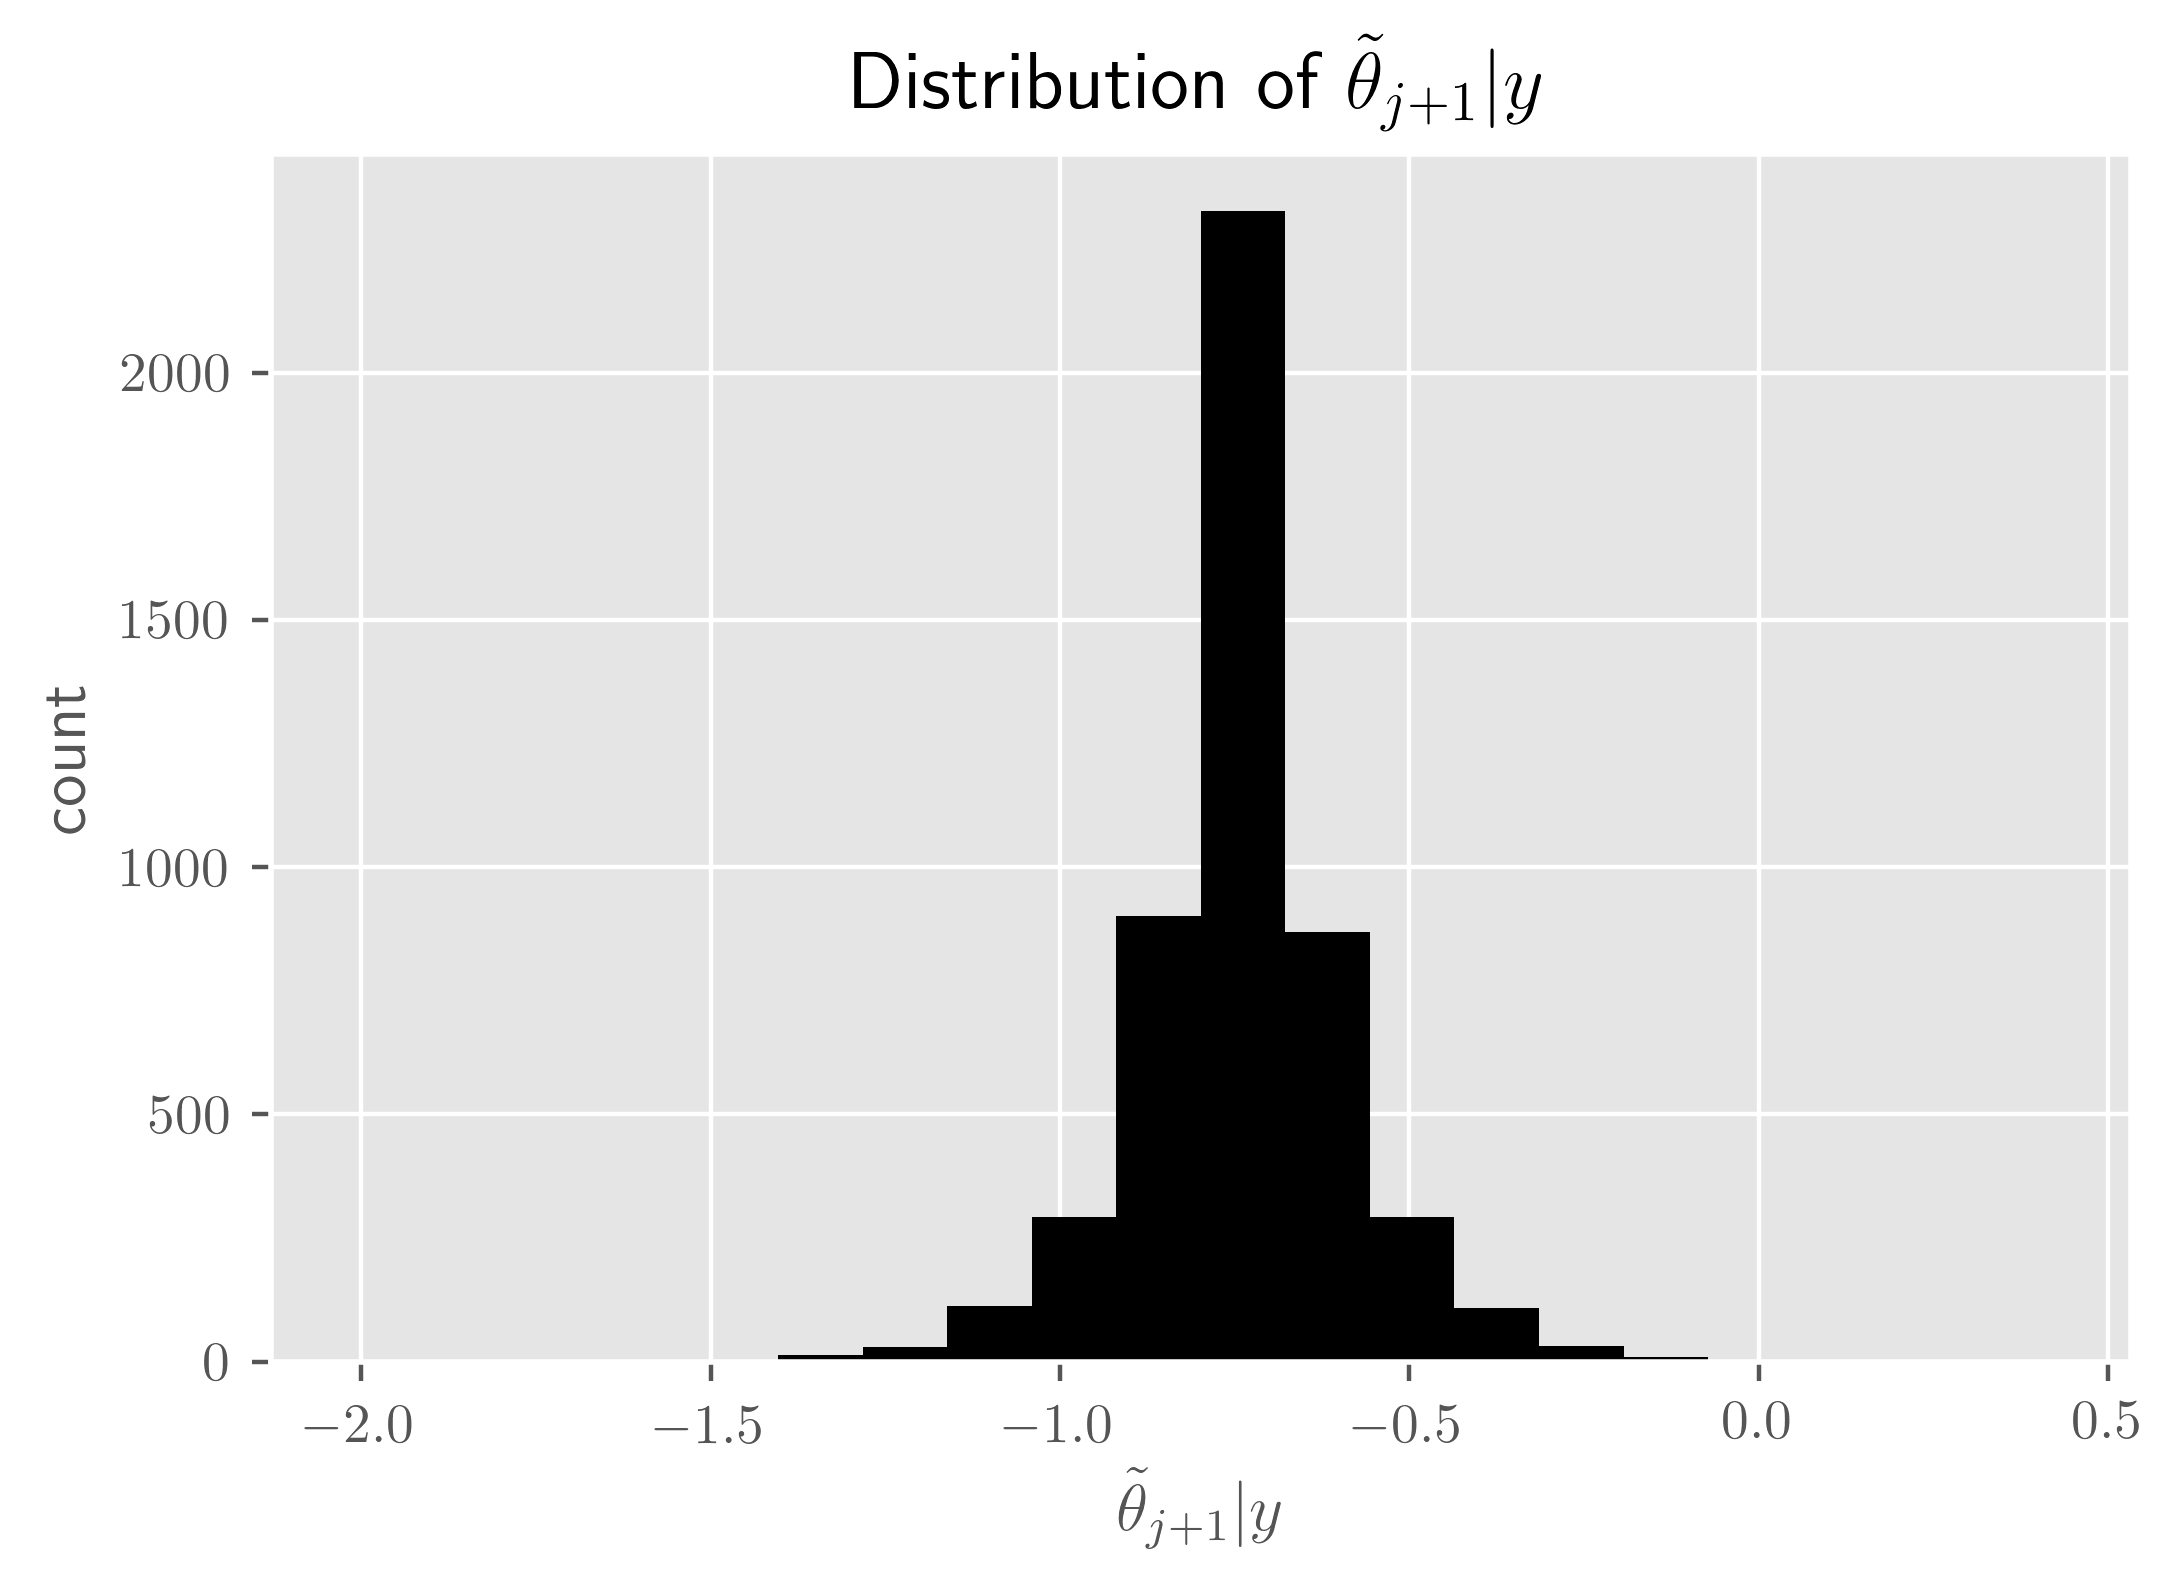

In [42]:
lower, upper = np.percentile(theta_sim, [2.5, 97.5])
print('95% Posterior predictive interval for theta j+1: [{:.3f}, {:.3f}]'\
       .format(lower, upper))

# plot it
with plt.style.context('ggplot'):
    plt.hist(theta_sim, bins=20, color='black')
    plt.xlabel(r'$\tilde{\theta}_{j+1} | y$')
    plt.ylabel(r'count')
    plt.title(r'Distribution of $\tilde{\theta}_{j+1} | y$')
    plt.show()

### (g)

Suppose the second study is to be repeated, under precisely the same conditions as the initial version: same basic protocol, subjects drawn from the same population, and, once again, 116 patients assigned to control and 114 to treatment. Give a 95% posterior predictive interval for $\tilde{y}_2$, the observed treatment effect in this replicated study.

In [37]:
n_sims = 5000
y_2 = y[1]
var_2 = sigma_2[1]

# sample p(tau | y)
tau_sim = np.random.choice(tau_range, n_sims, p=tau_posterior) + 0.0000001

# sample p(mu | tau, y)
V_mu = 1. / np.sum(1 / (var_2 + tau_sim**2))
mu_hat = V_mu * np.sum(y_2 / (var_2 + tau_sim**2))
mu_sim = np.random.normal(mu_hat, np.sqrt(V_mu), 5000)

# sample p(theta | mu, tau, y)
theta_sim = np.random.normal(mu_sim, tau_sim, 5000)

# sample p(y_tilde_2 | theta, mu, tau, y)
y_tilde_2_sim = np.random.normal(theta_sim, var_2)

95% Posterior predictive interval for theta j+1: [-1.301, -0.198]


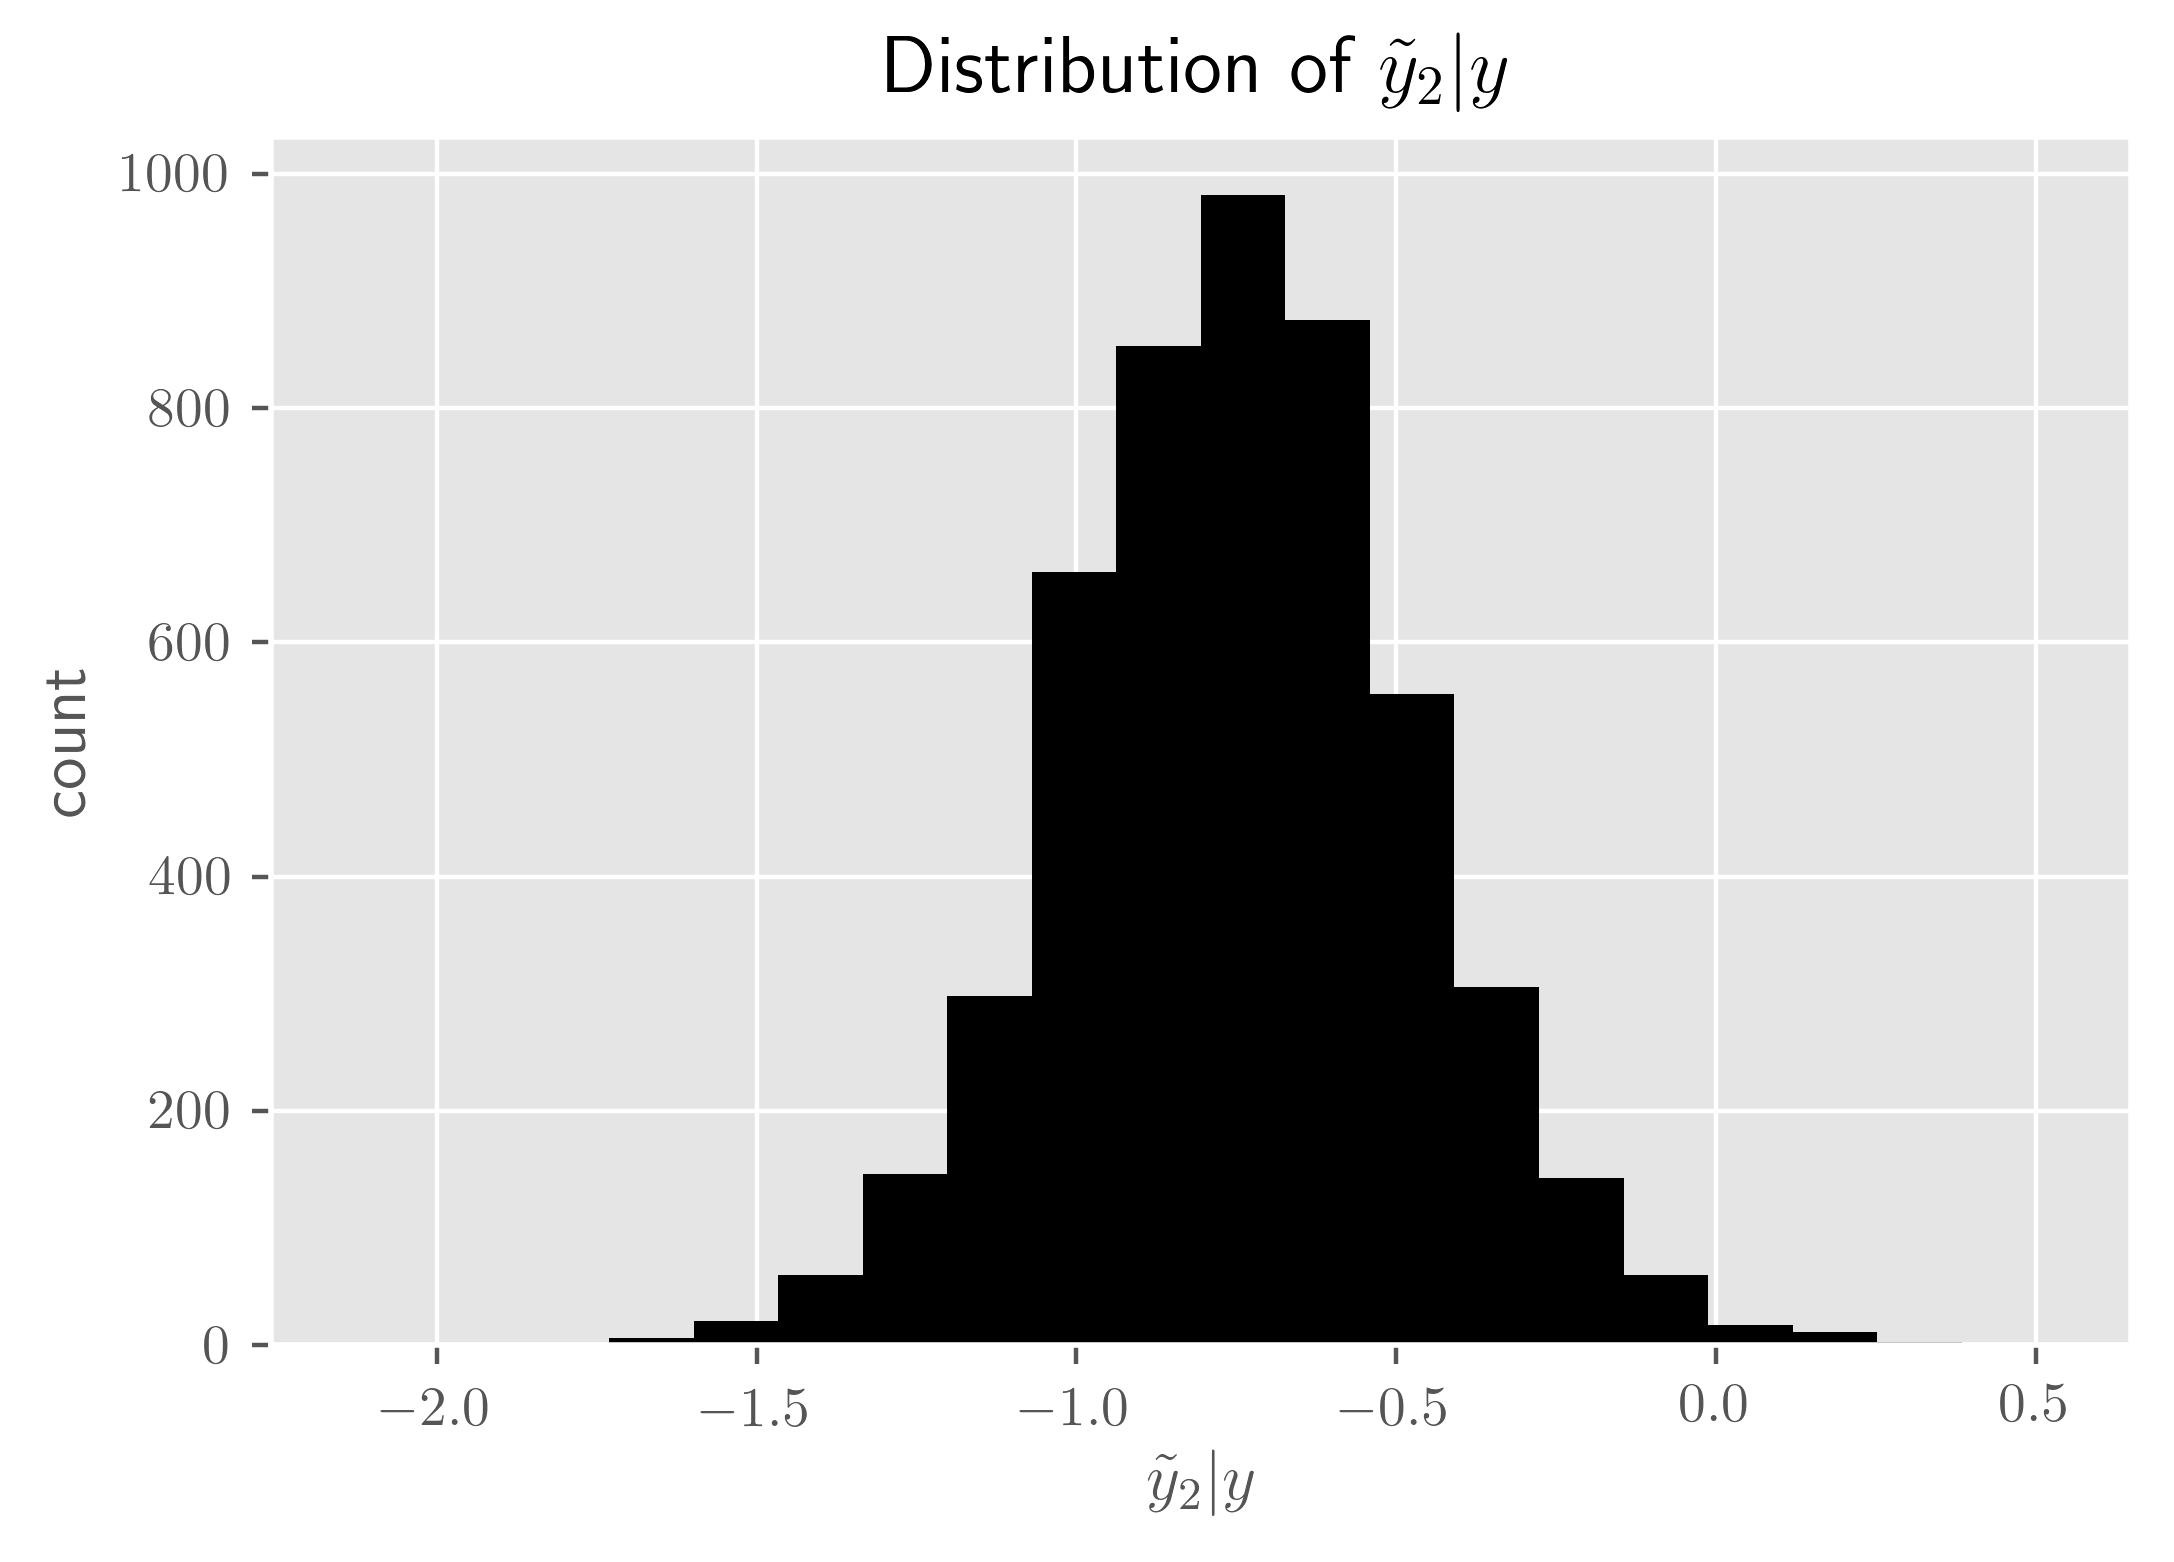

In [41]:
lower, upper = np.percentile(y_tilde_2_sim, [2.5, 97.5])
print('95% Posterior predictive interval for theta j+1: [{:.3f}, {:.3f}]'\
       .format(lower, upper))

with plt.style.context('ggplot'):
    plt.hist(y_tilde_2_sim, bins=20, color='black')
    plt.xlabel(r'$\tilde{y}_2 | y$')
    plt.ylabel(r'count')
    plt.title(r'Distribution of $\tilde{y}_2 | y$')
    plt.show()